# Import library

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torch.nn.functional as F
import torch.nn.init as init
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pickle
import random
from os.path import dirname, join as pjoin
import copy
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('visualization.ipynb'), '../')))
from utils.networks import *
from utils.trainer import *
from utils.formulations import *

datafolderpath = '../data'
saveresultfolderpath = '../experiment/result'
figurefolderpath = './saved_figures/'

def report_savefig(plotname, resultfolderpath = './', formattype = 'pdf', pad_margin = 0.01):
    fig.savefig(resultfolderpath + plotname + f'.{formattype}',format=formattype, 
                bbox_inches='tight',pad_inches=pad_margin,transparent=True)


def randomly_selected_date(df, num_dates=1, random_seed=None):
    # Create a copy of the DataFrame
    df = df.copy()

    # Get unique dates
    unique_dates = pd.Series(df.index.date).unique()

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Define the time range and frequency
    start_time = pd.to_datetime('06:45')
    end_time = pd.to_datetime('17:00')
    time_range = pd.date_range(start=start_time, end=end_time, freq='15T')

    selected_dates = []
    selected_dfs = []
    combined_mask = np.zeros(len(df), dtype=bool)  # Initialize combined mask

    while len(selected_dates) < num_dates:
        # Randomly select one date that hasn't been chosen yet
        random_date = np.random.choice(unique_dates)
        if random_date in selected_dates:
            continue  # Skip if the date has already been chosen

        # Filter the DataFrame for the selected date
        mask = df.index.date == random_date
        filtered_df = df[mask]

        # Randomly select one Site_id if there are multiple entries
        if filtered_df['Site_id'].nunique() > 1:
            selected_site_id = np.random.choice(filtered_df['Site_id'].unique())
            mask &= (df['Site_id'] == selected_site_id).to_numpy()
            filtered_df = filtered_df[filtered_df['Site_id'] == selected_site_id]

        # Check if all required times are present
        times_present = np.array([time in filtered_df.index.time for time in time_range.time])

        if (len(filtered_df) > 0 and  
            filtered_df.index[0].time() == pd.to_datetime('06:45').time() and all(times_present)):

            # Append to lists
            selected_dates.append(random_date)
            selected_dfs.append(filtered_df)
            combined_mask |= mask  # Update the combined mask

    # Concatenate all selected DataFrames into a single DataFrame
    random_dates_df = pd.concat(selected_dfs)

    return random_dates_df, combined_mask


# Import data

In [2]:
dict_path = os.path.join(datafolderpath, 'data_central_train_nonan.pkl')
with open(dict_path, 'rb') as pickle_file:
    data = pickle.load(pickle_file)
print(data.keys())

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

target_col = data['target_col']
features_list = data['features_list']
future_regressor = data['future_regressor']

df_train_date = data['df_train_date']
df_val_daTe = data['df_val_date']
df_test_date = data['df_test_date']

num_step_ahead = data['num_step_ahead']
resolution = data['resolution']

df_test_features = data['df_test_nonan'] # For feature plotting

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'target_col', 'features_list', 'future_regressor', 'df_train_nonan', 'df_val_nonan', 'df_test_nonan', 'df_train_date', 'df_val_date', 'df_test_date', 'timerange', 'num_step_ahead', 'resolution'])


# Import result

In [4]:
allresult_filename = ['sumk_solarcentral_4step_varylambda.pkl', 'sumk_lstm45_solarcentral_4step.pkl'
                      , 'qd_solarcentral_4step.pkl'
                      , 'cwcshri_solarcentral_4step.pkl', 'qr_solarcentral_4step.pkl']

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_ann = pickle.load(pickle_file)
print(result_sumk_ann.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'sumk_lstm45' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_sumk_lstm = pickle.load(pickle_file)
#     result_sumk_lstm = torch.load(pickle_file, map_location=torch.device('cpu'))
print(result_sumk_lstm.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qd' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qd = pickle.load(pickle_file)
print(result_qd.keys()) 

index_path = next((i for i, s in enumerate(allresult_filename) if 'cwcshri' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_cwcshri = pickle.load(pickle_file)
print(result_cwcshri.keys())

index_path = next((i for i, s in enumerate(allresult_filename) if 'qr' in s), None)
dict_path = os.path.join(saveresultfolderpath, allresult_filename[index_path])
with open(dict_path, 'rb') as pickle_file:
    result_qr = pickle.load(pickle_file)
print(result_qr.keys())

dict_path = os.path.join(saveresultfolderpath, 'point_solarcentral_4step.pkl')
with open(dict_path, 'rb') as pickle_file:
    result_point = pickle.load(pickle_file)
print(result_point.keys())

## Define model and trainer
train = trainer_multistep(num_epochs = 2000, batch_size = 2000, patience = 200) #Set the trainer

dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'PICP_val', 'PICP_test', 'PINAW_test', 'PINALW_test', 'gamma', 'lambda'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test', 'gamma'])
dict_keys(['outputs_train', 'outputs_val', 'outputs_test'])
dict_keys(['outputs_train_point', 'outputs_val_point', 'outputs_test_point'])


# Bar graph

In [5]:
key = 'outputs_test'
ydata = y_test
ydata_range = None

method_list = [result_qr[key], result_qd[key], result_cwcshri[key]
           , torch.tensor(result_sumk_ann[key][:,:,9]), result_sumk_lstm[key]]

formname = ['QR', 'QD', 'CWCshri', 'Sumk ANN', 'Sumk LSTM']
metrices_namelist = ['PICP', 'PINAW ($\wm$)', 'PINALW ($\wm$)', 'Winkler ($\wm$)']

picp_array = np.zeros((len(method_list), num_step_ahead))
pinaw_array = np.zeros((len(method_list), num_step_ahead))
pinalw_array = np.zeros((len(method_list), num_step_ahead))
winkler_array = np.zeros((len(method_list), num_step_ahead))

for i, method in enumerate(method_list):
    upper = method[:,1::2]
    lower = method[:,0::2]
    picp_array[i,:] = train.PICP(ydata, upper, lower)
    pinaw_array[i,:] = train.PINAW(upper, lower, ydata_range)
    pinalw_array[i,:] = train.PINALW(upper, lower, ydata_range, quantile = 0.5)
    winkler_array[i,:] = train.Winklerscore(upper, lower, ydata, ydata_range, delta = 0.1)
    
metric_list = [picp_array, pinaw_array, pinalw_array, winkler_array]

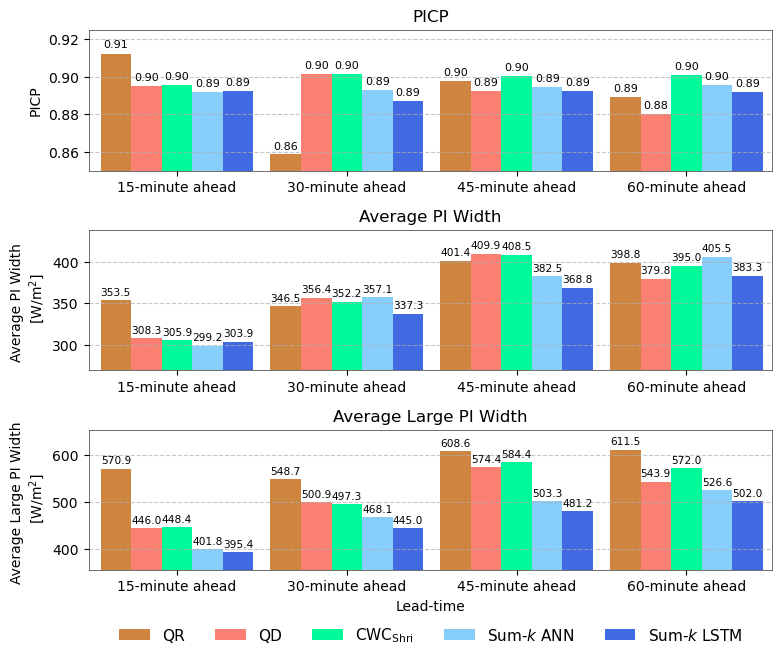

In [6]:
formname = ['QR', 'QD', r'$\text{CWC}_{\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']
horizons = ['15-minute ahead', '30-minute ahead', '45-minute ahead', '60-minute ahead']
width_plot_list = [picp_array, pinaw_array, pinalw_array]

fig, ax = plt.subplots(nrows = len(width_plot_list), figsize=(8, 2.25*len(width_plot_list)))
colors = ['peru', 'salmon', 'mediumspringgreen', 'lightskyblue', 'royalblue']
title_name = ['PICP', 'Average PI Width', 'Average Large PI Width']
ylabel_name = ['PICP', 'Average PI Width \n [W/m$^2$]', 'Average Large PI Width \n [W/m$^2$]']

ep = -0.02

for k, width_plot in enumerate(width_plot_list):
    # Parameters for bar plot
    num_horizons = width_plot.shape[1]  # Now this represents groups
    num_methods = width_plot.shape[0]   # Each horizon contains bars for different methods
    bar_width = 0.135
    indices = np.arange(num_horizons)*0.75
    offsets = [i * bar_width for i in range(num_methods)]

    for i, (method, offset) in enumerate(zip(formname, offsets)):
        ax[k].bar(indices + offset, width_plot[i], bar_width, label=method, color=colors[i])
        # Adding the numbers above each bar
        for j in range(num_horizons):
            if k == 0:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.002, f'{width_plot[i, j]:.2f}', ha='center', va='bottom'
                        , fontsize = 8)
                ax[k].set_ylim([0.85, 0.925])
            else:
                ax[k].text(indices[j] + offset, width_plot[i, j]*1.01, f'{width_plot[i, j]:.1f}', ha='center', va='bottom'
                        , fontsize = 7.6)
                ax[k].set_ylim([width_plot.min()*0.9, width_plot.max()*1.07])

    ax[k].grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
    # Labels and formatting
    if k == len(width_plot_list)-1:
        ax[k].set_xlabel('Lead-time')
    ax[k].set_ylabel(f'{ylabel_name[k]}')
#     ax[k].set_ylabel('Average PI Width \n W/m$^2$')
    ax[k].set_title(f'{title_name[k]}')
    ax[k].set_xticks(indices + bar_width * (num_methods - 1) / 2)
    ax[k].set_xticklabels(horizons)
#     ax[k].set_xlim([-0.1+ep,2.82-ep])
    ax[k].set_xlim([-0.1 + ep, 2.88 - ep])
#     ax[k].set_xlim(indices[0] - 0.2, indices[-1] + 0.2)
    # ax.legend(loc = 'upper left', fontsize = 8)
    if k == len(width_plot_list)-1:
        ax[k].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=num_methods, fontsize=11, frameon = False)
        
for axis in ax:
    for spine in axis.spines.values():
        spine.set_linewidth(0.4)

plt.tight_layout()
plt.show()
# report_savefig('bar_solar_performance_comparison_onecol', resultfolderpath = figurefolderpath)

# Timeseries plot of 15-minute ahead PIs

## Groupping data

In [7]:
df = df_test_date.copy()
lamb_index = 9
outputs_test_sumk_plot = torch.tensor(result_sumk_ann['outputs_test'][:,:,lamb_index])
upper_sumk = outputs_test_sumk_plot[:,1::2]
lower_sumk = outputs_test_sumk_plot[:,0::2]
width_sumk = upper_sumk - lower_sumk
df['width_sumk_ahead15'] = width_sumk[:,0]

upper_qd = result_qd['outputs_test'][:,1::2]
lower_qd = result_qd['outputs_test'][:,0::2]
width_qd = upper_qd - lower_qd
df['width_qd_ahead15'] = width_qd[:,0]

upper_sumk_lstm = result_sumk_lstm['outputs_test'][:,1::2]
lower_sumk_lstm = result_sumk_lstm['outputs_test'][:,0::2]
width_sumk_lstm = upper_sumk_lstm - lower_sumk_lstm
df['width_sumk_lstm_ahead15'] = width_sumk_lstm[:,0]

df['Date'] = df.index.date
time_range = pd.date_range(start='06:45', end='17:00', freq='15T').time
df['counttimeslot'] = df.groupby(['Site_id', 'Date']).transform('count')['width_sumk_ahead15']
# Extract only full timeslot in the date
df = df[df['counttimeslot'] == len(time_range)] 

grouped_df = df.groupby(['Site_id', 'skycondition', 'Date', 'counttimeslot']).agg(
    avg_width_sumk_ahead15=('width_sumk_ahead15', 'mean'),
    avg_width_qd_ahead15=('width_qd_ahead15', 'mean'),
    avg_width_sumk_lstm_ahead15=('width_sumk_lstm_ahead15', 'mean')
).reset_index()

grouped_df['deviation'] = grouped_df['avg_width_qd_ahead15'] - grouped_df['avg_width_sumk_ahead15']
grouped_df['model_deviation'] = grouped_df['avg_width_sumk_ahead15'] - grouped_df['avg_width_sumk_lstm_ahead15']

# List of sky conditions to iterate over
sky_conditions = ['clearsky', 'partlycloudy', 'cloudy']

## Randomly select the date

In [8]:
top_list = []
# Set the random seed for reproducibility (optional)
seed_list = [20, 20, 20]

# Select 4 random dates for each sky condition
for i, condition in enumerate(sky_conditions):
    np.random.seed(20)  
    # Filter the grouped DataFrame for the specific sky condition
    filtered_df = grouped_df[grouped_df['skycondition'] == condition]
    
    # Ensure there are at least 4 unique dates available
    unique_dates = filtered_df['Date'].unique()
    num_samples = min(4, len(unique_dates))  # Avoid errors if there are fewer than 4 dates
    
    # Randomly select 4 dates
    random_dates = np.random.choice(unique_dates, num_samples, replace=False)
    print(condition, random_dates)
    
    # Select rows corresponding to the chosen dates
    random_selection = filtered_df[filtered_df['Date'].isin(random_dates)]
    
    # Append to the list
    top_list.append(random_selection)

# Concatenate all top 5 DataFrames into a single DataFrame
top_deviation_combined = pd.concat(top_list, ignore_index=True)

# Define the specific Site_ids and corresponding dates
cloudcond_key_list = ['clearsky', 'partlycloudy', 'cloudy']
allconditions = []
for cloudcond in cloudcond_key_list:
    site_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Site_id'].to_numpy()
    date_list = top_deviation_combined[top_deviation_combined['skycondition']==cloudcond]['Date'].to_numpy()
    conditions = []
    for i in range(len(site_list)):
        cond = (df_test_date['Site_id'] == site_list[i]) & (df_test_date.index.date == date_list[i])
        conditions.append(cond)
    conditions = np.logical_or.reduce(conditions)
    allconditions.append(conditions)

# Define the plot characteristics
stepahead = 1
y_plot = y_test[:, stepahead - 1]
condname_list = ['Clear-sky', 'Partly Cloudy', 'Cloudy']
df_forindex = df_test_date.copy()
df_forindex['Date'] = df_forindex.index.date

# PI to plot (Place the reference in the last index)
# pi_plots = [result_qr['outputs_test'], result_cwcshri['outputs_test'], result_qd['outputs_test'], 
#             torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
# color_list = ['peru', 'forestgreen', 'salmon', 'darkturquoise', 'royalblue']
# formname_list = ['QR', '$\\text{CWC}_{\\text{Shri}}$', 'QD', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

pi_plots = [result_qr['outputs_test'], result_qd['outputs_test'], result_cwcshri['outputs_test'], 
            torch.tensor(result_sumk_ann['outputs_test'][:, :, 9]), result_sumk_lstm['outputs_test']]
color_list = ['peru', 'salmon', 'forestgreen', 'darkturquoise', 'royalblue']
formname_list = ['QR', 'QD', '$\\text{CWC}_{\\text{Shri}}$', 'Sum-$k$ ANN', 'Sum-$k$ LSTM']

clearsky [datetime.date(2023, 4, 15) datetime.date(2023, 1, 21)
 datetime.date(2023, 4, 21) datetime.date(2023, 12, 23)]
partlycloudy [datetime.date(2023, 7, 26) datetime.date(2023, 11, 16)
 datetime.date(2023, 6, 22) datetime.date(2023, 8, 10)]
cloudy [datetime.date(2023, 9, 4) datetime.date(2023, 10, 14)
 datetime.date(2023, 5, 3) datetime.date(2023, 9, 5)]


### Clear-sky

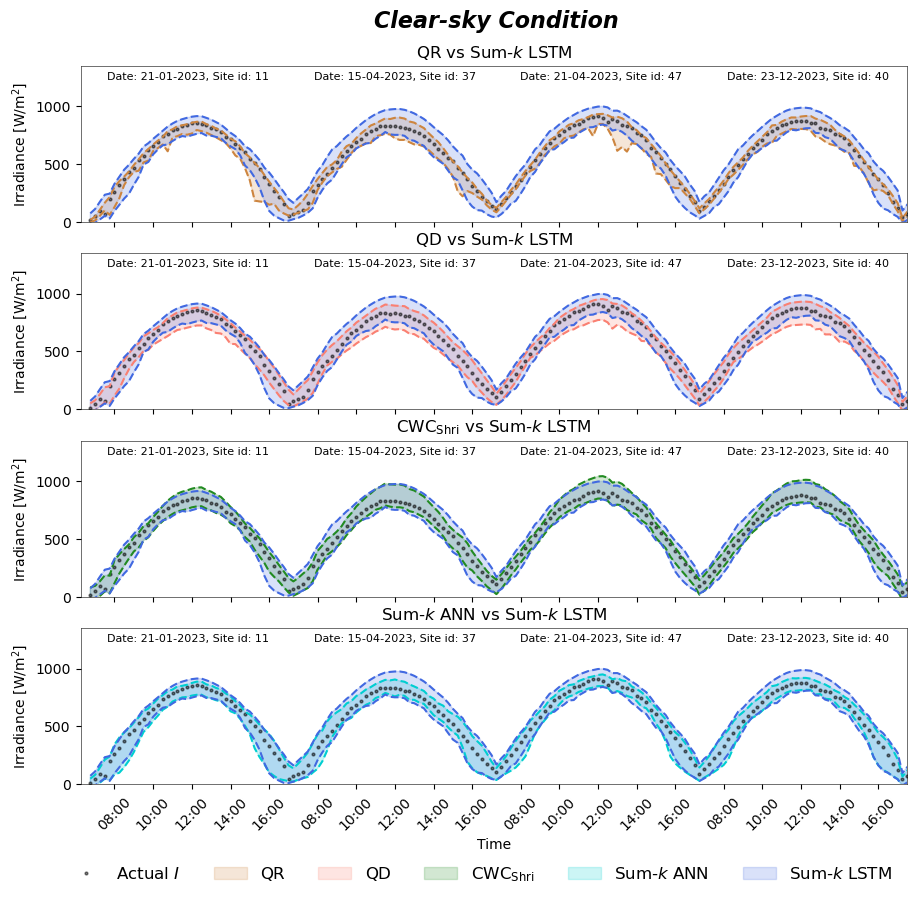

In [10]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)

condition = allconditions[0] # 0 - clear sky, 1 - partly cloudy, 2 - cloudy
y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=12, frameon=False)

fig.suptitle('Clear-sky Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_clearsky_comparison_randomdates', resultfolderpath = figurefolderpath)

### Partly cloudy

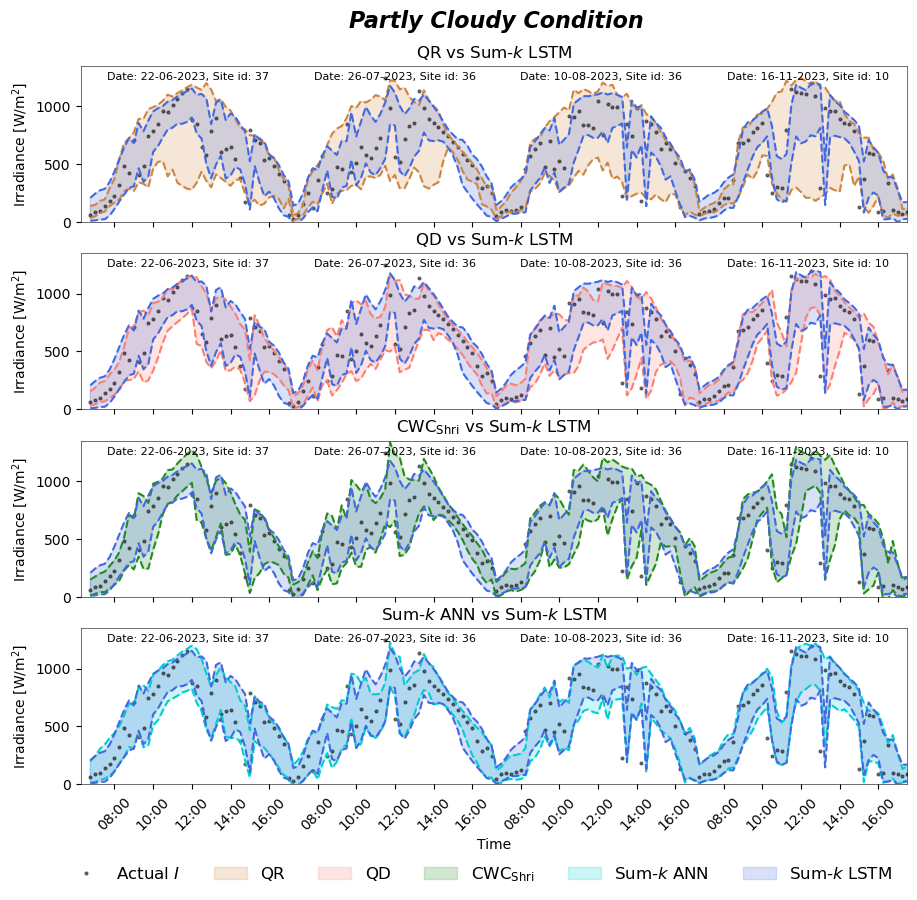

In [11]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)

condition = allconditions[1] # 0 - clear sky, 1 - partly cloudy, 2 - cloudy
y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=12, frameon=False)

fig.suptitle('Partly Cloudy Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_partlycloudysky_comparison_randomdates', resultfolderpath = figurefolderpath)

### Cloudy

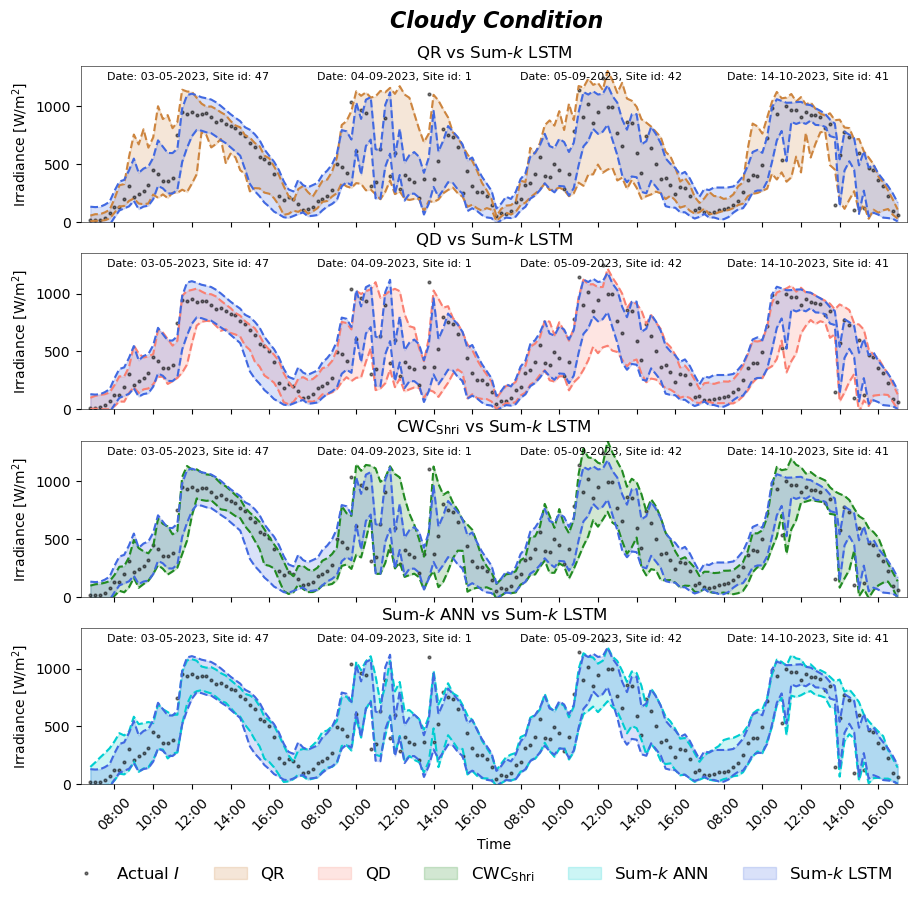

In [12]:
# fig, ax = plt.subplots(nrows=4, figsize=((4/3)*7, (4/3)*7))
fig, ax = plt.subplots(nrows=4, figsize=((4/3)*8, (4/3)*7))
plt.subplots_adjust(hspace=0.2)

condition = allconditions[2] # 0 - clear sky, 1 - partly cloudy, 2 - cloudy
y_plot_condition = y_plot[condition]
pi_ref = pi_plots[-1]

# Define the times you want to show (you can leave the dates out for this variable)
desired_times = ['08:00', '10:00', '12:00', '14:00', '16:00']
# Get the time values from the DataFrame index
time_values = df_forindex[condition].index
# Create a list of positions for the desired times
xtick_positions = [index for index, t in enumerate(time_values) if t.strftime('%H:%M') in desired_times]
# Create formatted labels that include the date and time
xtick_labels = [t.strftime('%H:%M') for t in time_values if t.strftime('%H:%M') in desired_times]

legend_handles = []
legend_labels = [r'Actual $I$'] + formname_list

for i, (pi, color, formname) in enumerate(zip(pi_plots, color_list, formname_list)):
    if i == len(pi_plots) - 1:  # Skip the last index
        break
    actual_plot, = ax[i].plot(y_plot_condition, color='black', label=r'Actual $I$',
           marker='.', linestyle='', markersize=4, alpha=0.5)
    if i == 0:
        legend_handles.append(actual_plot)
    pi_condition = pi[condition, 2 * (stepahead - 1):2 * stepahead]
    upper_plot = pi_condition[:, 1]
    lower_plot = pi_condition[:, 0]
    ax[i].plot(upper_plot, color=color, linestyle = 'dashed')
    ax[i].plot(lower_plot, color=color, linestyle = 'dashed')
    pi_benchmarked_plot = ax[i].fill_between(range(len(upper_plot)), lower_plot, upper_plot, color = color, 
                      alpha = 0.2, label = f'{formname}')
    legend_handles.append(pi_benchmarked_plot)
    
    pi_ref_condition = pi_ref[condition, 2 * (stepahead - 1):2 * stepahead]
    color_ref = color_list[-1]
    formname_ref = formname_list[-1]
    upper_plot_ref = pi_ref_condition[:, 1]
    lower_plot_ref = pi_ref_condition[:, 0]
    ax[i].plot(upper_plot_ref, color=color_ref, linestyle = 'dashed')
    ax[i].plot(lower_plot_ref, color=color_ref, linestyle = 'dashed')
    pi_ref_plot = ax[i].fill_between(range(len(upper_plot_ref)), lower_plot_ref, upper_plot_ref, color = color_ref, 
                      alpha = 0.2, label = f'{formname_ref}')
    
    if i == len(pi_plots) - 2:
        legend_handles.append(pi_ref_plot)

    # Set x-ticks and x-tick labels
    if i == len(pi_plots)-2:
        ax[i].set_xticks(xtick_positions)
        ax[i].set_xticklabels(xtick_labels, rotation=45)
        ax[i].set_xlabel('Time')
    else:
        ax[i].set_xticks(xtick_positions)  # Retain the ticks (dashes)
        ax[i].set_xticklabels([]) 

    ax[i].set_xlim([-2, 169])
    ax[i].set_ylim([0, 1350])
    ax[i].set_ylabel(r'Irradiance $[\text{W/m}^{2}]$')
    ax[i].set_title(f'{formname} vs Sum-$k$ LSTM')

#     if i == len(pi_plots)-2:
#         ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=  6, fontsize=10, frameon = False)

    text_list = []
    xcoor_fortext = [0.13, 0.38, 0.63, 0.88]
    for k in range(4):
        date_text = df_forindex.loc[condition, 'Date'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8].strftime('%d-%m-%Y')
        site_text = df_forindex.loc[condition, 'Site_id'].iloc[k*len(y_plot_condition)//4 + len(y_plot_condition)//8]
        text_add = f'Date: {date_text}, Site id: {site_text}'
        text_list.append(text_add)

        ax[i].text(xcoor_fortext[k], 0.9, text_add, ha='center', va='bottom', 
                   transform=ax[i].transAxes, fontsize=8)

    # Reduce the border line thickness
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.4)

# Add single legend at the bottom without duplicates
fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.04), 
           ncol=6, fontsize=12, frameon=False)

fig.suptitle('Cloudy Condition', fontsize=16, fontweight='bold', fontstyle='italic', y = 0.94, x = 0.515)
    
# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
# report_savefig('piplot_cloudysky_comparison_randomdates', resultfolderpath = figurefolderpath)